<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em></center>

# MNIST mit Multi-Layer Perceptron

In dieser Lektion werden wir ein Multi Layer Perceptron Modell erstellen und versuchen damit handgeschriebenen Zahlen zu klassifizieren. Das ist ein sehr verbreitetes Einsteigerproblem für Tensorflow.

Denkt daran, dass eine einzige Lektion niemals ausreichen wird, um Deep Learning und/oder Tensorflow in seiner Komlexität abzudecken!

## Die Daten laden

Wir werden die berühmten MNIST Daten über [handgeschriebenen Zahlen](http://yann.lecun.com/exdb/mnist/) verwenden.

Die Bilder die wir verwenden werden sind schwarz-weiß Bilder der größe 28 x 28, d.h. 784 Pixel insgesamt. Unsere Features werden die Pixelwerte für jeden Pixel sein. Entweder ist der Pixel "weiß" (also eine 0 in den Daten) oder er hat einen Pixelwert.

Wir werden versuchen korrekt vorherzusagen, welche Nummer geschrieben steht. Dazu verwenden wir lediglich die Bilddaten in Form unseres Arrays. Diese Art von Problem (Image Recognition oder auf Deutsch: Bilderkennung) ist ein tolle Use Case für Deep Learning Methoden!

Die Daten sind für Deep Learning das, was der Iris Datensatz für typische Machine Learning Algorithmen ist.

# Import von Bibliotheken in Python.

In diesem Code werden die Python-Bibliotheken TensorFlow, NumPy, Logging, Time, Matplotlib und Unittest importiert.

In [1]:
import tensorflow as tf
import numpy as np
import logging
import time
import matplotlib.pyplot as plt
import struct
import unittest
import psutil

In [ ]:
import psutil

print("Installierte psutil-Version:", psutil.__version__)

In [3]:
def max_ram_usage():
    max_memory = 0

    for interval in range(1, 11):
        memory_info = psutil.virtual_memory()
        max_memory = max(max_memory, memory_info.used)
        time.sleep(1)

    return max_memory / (1024 * 1024)  # In MB umrechnen

Dieser Code importiert verschiedene Python-Bibliotheken, lädt den MNIST-Datensatz, normalisiert die Daten, teilt sie in Trainings- und Testdaten auf und konvertiert die Trainingsdaten in das gewünschte Datenformat für spätere Verwendung.

In [4]:
from functools import wraps
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.datasets import mnist
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Pfad zu den heruntergeladenen MNIST-Daten
train_data_path = 'train-images.idx3-ubyte'
test_data_path = 't10k-images.idx3-ubyte'
train_labels_path = 'train-labels.idx1-ubyte'  # Hinzugefügt
test_labels_path = 't10k-labels.idx1-ubyte'  # Hinzugefügt

# Laden der MNIST-Daten aus den lokal gespeicherten Dateien
def load_mnist_data(data_path):
    with open(data_path, 'rb') as f:
        magic, num_images, num_rows, num_cols = struct.unpack('>IIII', f.read(16))
        images = np.fromfile(f, dtype=np.uint8).reshape(num_images, num_rows, num_cols)
    return images

# Laden der MNIST-Label aus den lokal gespeicherten Dateien (Hinzugefügt)
def load_mnist_labels(labels_path):
    with open(labels_path, 'rb') as f:
        magic, num_labels = struct.unpack('>II', f.read(8))
        labels = np.fromfile(f, dtype=np.uint8)
    return labels

# Laden Sie die MNIST-Trainings- und Testdaten
x_train_mnist = load_mnist_data(train_data_path)
x_test_mnist = load_mnist_data(test_data_path)
# Laden Sie die MNIST-Label
train_labels = load_mnist_labels(train_labels_path)
test_labels = load_mnist_labels(test_labels_path)

# Normalisieren der Daten
class Normalize(object):
    def normalize(self, X_train, X_test):
        self.scaler = MinMaxScaler()
        # Umformen in 2D-Arrays (Flatten)
        X_train = X_train.reshape(X_train.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        X_train = self.scaler.fit_transform(X_train)
        X_test = self.scaler.transform(X_test)
        return (X_train, X_test)

    def inverse(self, X_train, X_test):
        X_train = self.scaler.inverse_transform(X_train)
        X_test = self.scaler.inverse_transform(X_test)
        return (X_train, X_test)

# Aufteilen der Daten
def split(X, y, splitRatio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    return (X_train, y_train, X_test, y_test)

# Annahme: Sie haben bereits die MNIST-Trainings- und Testdaten geladen und in x_train_mnist und x_test_mnist gespeichert.

# Normalisieren der Daten
normalizer = Normalize()
x_train, x_test = normalizer.normalize(x_train_mnist, x_test_mnist)

# Aufteilen der Daten
splitRatio = 0.8  # Ändern Sie den Split-Verhältnis nach Bedarf
x_train, y_train, x_test, y_test = split(x_train, train_labels, splitRatio)

# Stellen Sie sicher, dass die Daten korrekt geladen wurden (ersetzen Sie y durch die entsprechenden Label-Daten)
assert x_train.shape == (int(0.8 * len(x_train_mnist)), x_train_mnist.shape[1] * x_train_mnist.shape[2])
assert x_test.shape == (int(0.2 * len(x_train_mnist)), x_train_mnist.shape[1] * x_train_mnist.shape[2])
assert y_train.shape == (int(0.8 * len(x_train_mnist)),)
assert y_test.shape == (int(0.2 * len(x_train_mnist)),)

## Definieren der my_logger und my_timer Funktion

In [5]:
def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper

In [6]:
def my_timer(orig_func):
    import time

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

In diesem Code wird eine Python-Klasse mit dem Namen "TheAlgorithm" definiert, die verschiedene Methoden wie den Konstruktor __init__, die Methode fit und die Methode predict enthält, wobei die Dekoratoren @my_logger und @my_timer verwendet werden, um die Ausführung dieser Methoden zu protokollieren und die Zeitmessung durchzuführen.

In [7]:
class TheAlgorithm(object):
    @my_logger
    @my_timer
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test

    @my_logger
    @my_timer
    def fit(self):
        x_train, y_train, x_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test

        normalizer = Normalize()  # Use the correct class name here
        x_train, x_test = normalizer.normalize(x_train, x_test)

        train_samples = x_train.shape[0]

        self.classifier = LogisticRegression(
            C=50. / train_samples,
            multi_class='multinomial',
            penalty='l1',
            solver='saga',
            tol=0.1,
            class_weight='balanced',
        )

        self.classifier.fit(x_train, y_train)
        self.train_predictions = self.classifier.predict(x_train)
        self.train_accuracy = np.mean(self.train_predictions.ravel() == y_train.ravel()) * 100
        self.train_confusion_matrix = confusion_matrix(y_train, self.train_predictions)
        return self.train_accuracy

    @my_logger
    @my_timer
    def predict(self):
        x_test = self.X_test  # Test data doesn't need to be normalized again

        self.test_predictions = self.classifier.predict(x_test)
        self.test_accuracy = np.mean(self.test_predictions.ravel() == self.y_test.ravel()) * 100
        self.test_confusion_matrix = confusion_matrix(self.y_test, self.test_predictions)
        self.report = classification_report(self.y_test, self.test_predictions)
        print("Classification Report for the classifier:\n%s\n" % (self.report))

        return self.test_accuracy


## Daten Format

Die Daten sind im Vektor Format gespeichert, obwohl die Originaldaten eine 2-dimensionale Matrix waren, die angab, wie viele Pigmente sich an welcher Position befinden. Untersuchen wir das genauer:

In [8]:
type(mnist)

module

In [9]:
type(x_train)
type(y_train)

numpy.ndarray

In [10]:
x_train[2].shape

(784,)

In [11]:
sample = x_train[2].reshape(28, 28)

In [12]:
%matplotlib inline

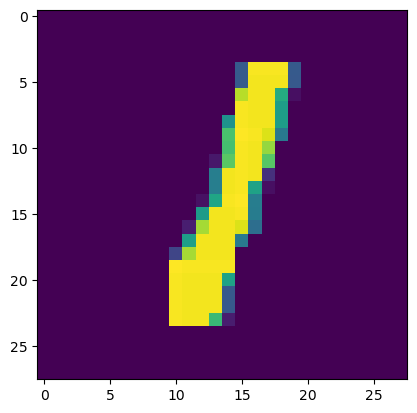

In [13]:
plt.imshow(sample)

## Parameter

Wir werden 4 Parameter definieren müssen. Es ist wirklich (wirklich) schwer gute Parameterwerte für einen Datensatz zu bestimmen, mit dem man keine Erfahrung hat. Da dieser MNIST Datensatz allerdings so berühmt ist haben wir schon einige Ausgangswerte. Die Parameter sind:

* Learning Rate - Wie schnell die Kostenfunktion angepasst wird
* Traing Epochs - Wie viele Trainingszyklen durchlaufen werden sollen
* Batch Size - Größe der "Batches" an Traingsdaten

In [14]:
# Parameter
learning_rate = 0.001
training_epochs = 15
batch_size = 100

### Netzwerk Parameter

Hier haben wir Parameter welche unser Neuronales Netz direkt definieren. Diese werden entsprechend der betrachteten Daten angepasst und hängen auch davon ab, welche Art von Netz man nutzt. Es sind bis zu diesem Punkt erst einmal nur Zahlen, die wir später verwenden, um unser Netz zu definieren:

In [15]:
# Netzwerk Parameter
n_hidden_1 = 256  # 1. Layer: Anzahl an Features
n_hidden_2 = 256  # 2. Layer: Anzahl an Features
n_input = 784     # MNIST Daten Input (img shape: 28*28)
n_classes = 10    # MNIST Klassen (0-9 Zahlen)
n_samples = len(x_train)  # Anzahl der Trainingsbeispiele

### Tensorflow Graph Input

In [16]:
x = tf.keras.Input(shape=(n_input,), dtype=tf.float32)
y = tf.keras.Input(shape=(n_classes,), dtype=tf.float32)

## MultiLayer Modell

Es ist Zeit unser Modell zu erstellen. Wiederholen wir deshalb kurz, was wir erstellen wollen:

Zuerst erhalten wir einen *Input* in Form eines Datenarrays und schicken diesen an die erste *Hidden Layer*. Dann wird den Daten ein  *Weight* zwischen den Schichten zugewiesen (welches zuerst ein zufälliger Wert ist). Anschließend wird es an einen *Node* geschicht und unterläuft eine *Activation Function* (zusammen mit einem Bias, wie in der Neural Network Lektion erwähnt). Dann geht es weiter zur nächsten *Layer* und immer so weiter, bis zur finalen *Output Layer*. In unserem Fall werden wir nur 2 *Hidden Layers* verwenden. Je mehr wir davon verwenden, desto länger braucht das Modell (aber er hat mehr Möglichkeiten um die Genauigkeit zu erhöhen).

Sobald die transformierte Daten die *Output Layer* erreicht haben müssen wir sie auswerten. Hier verwenden wir eine *Loss Function* (auch Cost Function genannt). Diese berechnet, wie sehr wir vom gewünschten Ergebnis entfernt sind. In diesem Fall: Wie viele der Klassen wir richtig zugeteilt haben.

Dann wenden wir eine Optimierungsfunktion an, um die *Costs* (bzw. den Error) zu minimieren. Dies geschiet durch die Anpassung der *Weights* entlang des Netzes. Wir verwenden in unserem Beispiel den [Adam Optimizer](https://arxiv.org/pdf/1412.6980v8.pdf), welcher eine (im Vergleich zu anderen) sehr neue Entwicklung ist.

Wir können anpassen, wie schnell diese Optimierung angewendet wird, indem wir unseren *Learning Rate* Parameter anpassen. Je geringer die Rate, desto höher die Möglichkeiten für Anpassungen. Dies erzeugt allerdings die Kosten einer erhöhten Wartezeit. Ab einem bestimmten Punkt lohnt es sich nicht mehr, die Learning Rate weiter zu senken.

Jetzt können wir unser Modell erstellen. Wir beginnen mit 2 Hidden Layers, welche die []() Activation Function verwenden. Dies ist eine einfache Umformungsfunktion, die entweder x oder 0 zurückgibt. Für unsere finale Output Layer verwenden wir eine lineare Activation mit Matrixmultiplikation:

In diesem Code wird eine Funktion namens "multilayer_perceptron" definiert, die ein mehrschichtiges neuronales Netzwerk mit ReLU-Aktivierungsfunktionen für die Hidden Layers und linearer Aktivierungsfunktion für die Output Layer erstellt und die Ausgabe des Netzwerks zurückgibt, wobei die Funktionen `my_logger` und `my_timer` als Dekoratoren verwendet werden, um die Ausführung der Funktion zu protokollieren und die Zeitmessung durchzuführen.

In [17]:
@my_logger
@my_timer
def multilayer_perceptron(x, weights, biases):
    '''
    x : Platzhalter für den Dateninput
    weights: Dictionary der Weights
    biases: Dictionary Der Biases
    '''
    
    # Erste Hidden layer mit RELU Activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Zweite Hidden layer mit RELU Activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Letzte Output layer mit linearer Activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

## Weights und Bias

Damit unser Tensorflow Modell funktioniert müssen wir zwei Dictionaries anlegen, die unsere Weights und Biases enthalten. Wir können das `tf.variable` Objekt verwenden. Dies ist anders als eine Konstante, da Tensorflow's Graph Objekt alle Zustände der Variablen wahrnimmt. Eine Variable ist ein anpassbares Tensor, der zwischen Tensorflow's Graph von interagierenden Operationen lebt. Er kann durch die Berechnung verwendet und verändert werden. Wir werden die Modell Parameter generell als Variablen verwenden. Aus der Dokumentation können wir entnehmen:

    A variable maintains state in the graph across calls to `run()`. You add a variable to the graph by constructing an instance of the class `Variable`.

    The `Variable()` constructor requires an initial value for the variable, which can be a `Tensor` of any type and shape. The initial value defines the type and shape of the variable. After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.
    
Wir werden Tensorflow's eingebaute `random_normal` Methode verwenden, um zufällige Werte für unsere Weights und Biases zu erstellen.

In [18]:
# Gewichtsinitialisierung
weights = {
    'h1': tf.Variable(tf.initializers.RandomNormal()(shape=[n_input, n_hidden_1])),
    'h2': tf.Variable(tf.initializers.RandomNormal()(shape=[n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.initializers.RandomNormal()(shape=[n_hidden_2, n_classes]))
}

In [19]:
# Bias-Initialisierung
biases = {
    'b1': tf.Variable(tf.random.normal([n_hidden_1])),
    'b2': tf.Variable(tf.random.normal([n_hidden_2])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

In [20]:
# Model erstellen
pred = multilayer_perceptron(x, weights, biases)

multilayer_perceptron ran in: 0.046897172927856445 sec


## Cost und Optimierungs-Funktion

Wir verwenden Tensorflow's eingebaute Funktionen für diesesn Teil. Weitere Details bietet die Dokumentation:

In [21]:
# Cost und Optimierungsfunktion definieren
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = y, logits=pred))

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

### Initialisierung der Variablen

Wir initialisieren nun alle tf.Variable Objekte die wir zuvor erstellt haben. Das wird das erste sein, dass wir ausführen, wenn wir unser Modell trainieren.

## Das Modell trainieren

### next_batch()

Bevor wir beginnen möchte ich eine weitere nützliche Funktion in unserem MNIST Datenobjekt abdecken, die `next_batch` heißt. Diese gibt ein Tupel in der Form (X,y) mit einem X Array der Daten und einem y Array der Klasse. Zum Beispiel:

In [23]:
# Erstelle ein TensorFlow-Dataset aus den Trainingsdaten
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Mische die Daten und teile sie in Batches auf
batch_size = 1
train_dataset = train_dataset.shuffle(buffer_size=len(x_train)).batch(batch_size)

# Erstelle einen Iterator für das Dataset
train_iterator = iter(train_dataset)

# Greife auf ein Batch von Daten zu
Xsamp, ysamp = next(train_iterator)

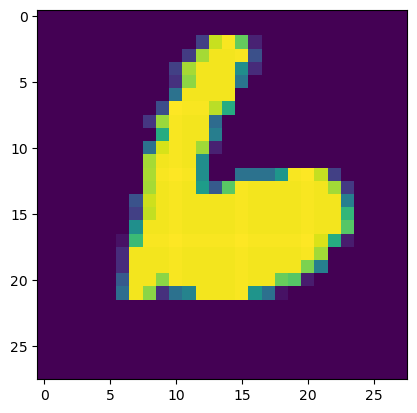

In [24]:
# Wandele Xsamp in ein Numpy-Array um
Xsamp_numpy = Xsamp.numpy()

# Zeige das Bild mit imshow
plt.imshow(Xsamp_numpy.reshape(28, 28))

In [25]:
print(ysamp)

tf.Tensor([6], shape=(1,), dtype=uint8)


In [26]:
def my_logger(orig_func):
    logging.basicConfig(filename='{}.log'.format(orig_func.__name__), level=logging.INFO)

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        logging.info(
            'Ran with args: {}, and kwargs: {}'.format(args, kwargs))
        return orig_func(*args, **kwargs)

    return wrapper
def my_timer(orig_func):

    @wraps(orig_func)
    def wrapper(*args, **kwargs):
        t1 = time.time()
        result = orig_func(*args, **kwargs)
        t2 = time.time() - t1
        print('{} ran in: {} sec'.format(orig_func.__name__, t2))
        return result

    return wrapper

## Die Session ausführen

Jetzt ist es Zeit unsere Session auszuführen! Achte darauf wie wir zwei Schleifen verwenden. Die äußere, die die Epochs durchläuft, und die innere, die die Batches für jede Epoch des Trainings ausführt.

## Wichtig, hier wurden aus zeitlichen Gründen mit 1% der Daten gearbeitet. Der Code ist mit jeder Prozentzahl reproduzierbar.

Es wurde aus zeitlicher und übersichtlicher Sicht eine View sowie eine Abfrage des gewünschten Prozentsatzes eingebaut.

In [27]:
# from tensorflow import keras

# Eingabe vom Benutzer: Prozentsatz der Daten, die verarbeitet werden sollen
percentage_to_process = float(input("Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): "))

# Berechnen Sie die Anzahl der Datensätze, die verarbeitet werden sollen
n_samples_to_process = int(n_samples * (percentage_to_process / 100))

# Training Epochs
for epoch in range(training_epochs):
    avg_cost = 0.0

    total_batch = int(n_samples_to_process / batch_size)

    for i in range(total_batch):

        # Den nächsten Batch an Trainingsdaten und -labels nehmen

        batch_x = tf.cast(x_train[i * batch_size: (i + 1) * batch_size], tf.float32)
        batch_y = tf.cast(y_train[i * batch_size: (i + 1) * batch_size], tf.float32)

        # Führen Sie die Optimierung und Cost-Berechnung durch

        with tf.GradientTape() as tape:

            pred = multilayer_perceptron(batch_x, weights, biases)

            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=batch_y, logits=pred))

        gradients = tape.gradient(loss, list(weights.values()) + list(biases.values()))
        optimizer.apply_gradients(zip(gradients, list(weights.values()) + list(biases.values())))

        avg_cost += loss / total_batch

    print("Epoch: {} Cost={:.4f}".format(epoch + 1, avg_cost))

print("Modellierung ist beendet: {} Epochs of Training".format(training_epochs))

Geben Sie den Prozentsatz der Daten ein, der verarbeitet werden soll (0-100): 1
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511688232421875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625715255737305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_p

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565265655517578 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015612602233886719 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percep

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000186920166016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400233268737793 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0040013790130615234 sec
multilayer_perceptron ran in: 0.004000663757324219 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.003988027572631836 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.003998517990112305 sec
multilayer_perceptron ran in: 0.00398707389831543 sec
multilayer_perceptron ran in: 0.003999948501586914 sec
multilayer_perceptron ran in: 0.00400090217590332 

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039997100830078125 sec
multilayer_perceptron ran in: 0.003999233245849609 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.003999948501586914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004019498825073242 sec
multilayer_perceptron ran in: 0.004018068313598633 sec
multilayer_perceptron ran in: 0.003998279571533203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400233268737793 sec
multilayer_perceptron ran in: 0.004000663757324219 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039937496185302734 sec
multilayer_perceptron ran in: 0.0039837360382080

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004010915756225586 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000663757324219 sec
multilayer_perceptron ran in: 0.004001140594482422 sec
multilayer_perceptron ran in: 0.003998756408691406 sec
multilayer_perceptron ran in: 0.004000186920166016 sec
multilayer_perceptron ran in: 0.004001617431640625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000663757324219 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039899349212646484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.003985166549682617 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039997100830078125 sec
multilayer_pe

multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039997100830078125 sec
multilayer_perceptron ran in: 0.00400233268737793 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039997100830078125 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.003999233245849609 sec
multilayer_perceptron ran in: 0.00400853157043457 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000663757324219 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0040018558502197266 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran i

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039031505584716797 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400090217590332 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400543212890625 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400233268737793 sec
multilayer_perceptron ran in: 0.0040013790130615234 sec
mult

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015643835067749023 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015627384185791016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626192092895508 sec

multilayer_perceptron ran in: 0.015623092651367188 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015634775161743164 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156557559967041 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percept

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635251998901367 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015637874603271484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006520509719848633 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004014015197753906 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0040132999420166016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004011869430541992 sec
multilayer_perceptron ran in: 0.003999948501586914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004014492034912109 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000186920166016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039975643157958984 sec
multi

multilayer_perceptron ran in: 0.004000186920166016 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 5 Cost=31516.5430
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.003999233245849609 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0040051937103271484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0039882659912109375 sec
multilayer_perceptron ran in: 0.003999948501586914 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400090217590332 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004004001617431641 sec
multilayer_perceptron ran in: 0.0010004043579101562 sec
mu

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004001617431640625 sec
multilayer_perceptron ran in: 0.004003763198852539 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000186920166016 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00400090217590332 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.0 sec
multilay

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.003999948501586914 sec
multilayer_perceptron ran in: 0.0039997100830078125 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.004000425338745117 sec
multilayer_perceptron ran in: 0.004000186920166016 sec
mu

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 s

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01565384864807129 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638113021850586 sec
multilayer_perceptron ran in: 0.015628337860107422 sec
multilayer_perceptron ran in: 0.015646696090698242 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006507158279418945 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptro

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562666893005371 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006509065628051758 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015635013580322266 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.00652313232421875 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron 

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638113021850586 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0010161399841308594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563858985900879 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015640735626220703 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015622854232788086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015649080276489258 sec

multilayer_perceptron ran in: 0.0020034313201904297 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562952995300293 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01563239097595215 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015624046325683594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006523609161376953 sec
mult

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015625476837158203 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015651464462280273 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015639543533325195 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015650033950805664 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564192771911621 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
m

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 s

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015630245208740234 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006529808044433594 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015642404556274414 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006522417068481445 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01561880111694336 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec


multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564192771911621 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015656232833862305 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percep

multilayer_perceptron ran in: 0.015658140182495117 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006528615951538086 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015623807907104492 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01564311981201172 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015638351440429688 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
mult

multilayer_perceptron ran in: 0.015638351440429688 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015626907348632812 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01580810546875 sec
mul

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562643051147461 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0020151138305664062 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.01562190055847168 sec
multilayer_perce

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.015637874603271484 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0156252384185791 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_percept

multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.006511211395263672 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
multilayer_perceptron ran in: 0.0 sec
Epoch: 15 Cost=158148.8438
Modellierung ist beendet: 15 Epochs of Training


## Modell Auswertung

Tensorflow bietet einige eingebaute Funktionen, die uns bei der Auswertung helfen. Dazu gehören `tf.equal` und `tf.reduce_mean`.


### tf.equal

Dies ist im Grunde genommen nur eine Kontrolle, ob die Vorhersagen mit den Labels übereinstimmen. Da wir in unserem Fall wissen, dass die Labels eine 1 in einem Array von Nullen sind, können wir `argmax()` verwenden, um die Position zu vergleichen. Denke daran, dass y immer noch der Platzhalter ist, den wir anfangs erstellt haben. Wir werden eine Reihe an Operationen durchführen, um einen Tensor zu erhalten, in den wir die Testdaten einlesen können, um es auszuwerten.

In [28]:
# Teste das Modell
correct_predictions = tf.math.reduce_all(tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1)))

In [29]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.bool, name=None), name='tf.math.reduce_all/All:0', description="created by layer 'tf.math.reduce_all'")


Um numerische Werte für unsere Vorhersagen zu erhalten müssen wir `tf.cast` verwenden, um den Tensor mit Booleans zurückzuführen in einen Tensor mit Floats. Dann können wir den Durchschnitt nehmen.

In [30]:
correct_predictions = tf.cast(correct_predictions, "float")

In [31]:
print(correct_predictions)

KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.cast/Cast:0', description="created by layer 'tf.cast'")


Jetzt können wir `tf.reduce_mean` verwenden, um den Durchschnitt der Elemente im Tensor zu erhalten:

In [32]:
accuracy = tf.reduce_mean(correct_predictions)

In [33]:
type(accuracy)

keras.engine.keras_tensor.KerasTensor

Das wirkt evtl. etwas merkwürdig, aber diese Genauigkeit ist immer noch ein Tensor Objekt. Denke daran, dass wir immer noch die tatsächlichen Testdaten übergeben müssen. Jetzt können wir die MNIST Testlabels und Bilder aufrufen und die Genauigkeit auswerten!

In [34]:
y_test

array([7, 3, 8, ..., 9, 7, 2], dtype=uint8)

In [35]:
x_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Die `eval()` Methode erlaubt es uns direkt in der Session den Tensor auszuwerten ohne `tf.sess():mm` aufrufen zu müssen

In [36]:
# Überprüfen, ob eine GPU verfügbar ist
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("GPU gefunden. Aktiviere GPU-Unterstützung.")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Keine GPU gefunden. Verwende die CPU.")

# Erstellen des Modells
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(n_input,)),  
    tf.keras.layers.Dense(n_hidden_1, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_hidden_2, activation=tf.nn.relu),
    tf.keras.layers.Dense(n_classes, activation=None)
])

# Kompilieren des Modells mit der Genauigkeitsmetrik
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Trainieren des Modells auf den Trainingsdaten in Batches mit einer erhöhten Batch-Größe
x_train_flattened = x_train.reshape(-1, n_input)
batch_size = 128  # Erhöhen Sie die Batch-Größe, um die GPU besser auszulasten
model.fit(x_train_flattened, y_train, batch_size=batch_size, epochs=training_epochs)

# Evaluieren der Genauigkeit auf den Testdaten (nur am Ende)
x_test_flattened = x_test.reshape(-1, n_input)
test_loss, test_accuracy = model.evaluate(x_test_flattened, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Keine GPU gefunden. Verwende die CPU.
Epoch 1/15
375/375 [==============================] - 1s 3ms/step - loss: 0.2887 - sparse_categorical_accuracy: 0.9166
Epoch 2/15
375/375 [==============================] - 1s 3ms/step - loss: 0.1093 - sparse_categorical_accuracy: 0.9673
Epoch 3/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0709 - sparse_categorical_accuracy: 0.9781
Epoch 4/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0495 - sparse_categorical_accuracy: 0.9851
Epoch 5/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0364 - sparse_categorical_accuracy: 0.9882
Epoch 6/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0265 - sparse_categorical_accuracy: 0.9919
Epoch 7/15
375/375 [==============================] - 1s 2ms/step - loss: 0.0219 - sparse_categorical_accuracy: 0.9933
Epoch 8/15
375/375 [==============================] - 1s 3ms/step - loss: 0.0189 - sparse_categorical_accuracy: 0.9936
Epoch 9/15

# Initialisieren des Unittest

Hier startet der Unittest, zu anfang werden die Datenausgelesen und anschließend die Train Accuracy und Test Accurracy ausgegeben.

In [37]:
if __name__ == '__main__':
    X = x_train  # Hier die x_train-Matrix verwenden
    y = y_train  # Hier die y_train-Matrix verwenden
    print('MNIST:', X.shape, y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
    np.random.seed(31337)
    ta = TheAlgorithm(X_train, y_train, X_test, y_test)
    train_accuracy = ta.fit()
    print()
    print('Train Accuracy:', train_accuracy, '\n')
    print("Train confusion matrix:\n%s\n" % ta.train_confusion_matrix)
    test_accuracy = ta.predict()
    print()
    print('Test Accuracy:', test_accuracy, '\n')
    print("Test confusion matrix:\n%s\n" % ta.test_confusion_matrix)

MNIST: (48000, 784) (48000,)
__init__ ran in: 0.0 sec
fit ran in: 12.277299404144287 sec

Train Accuracy: 72.53645833333333 

Train confusion matrix:
[[3544    5   19   17   25    5  106   22   39    3]
 [   3 4153   66   28    2   19   19   18   13    0]
 [ 255  296 2386  106  178   15  413  105   71   36]
 [ 113  159  172 2834   38  169   64   80  145  116]
 [  77   88   14   31 2874  201  134   79   42  165]
 [ 328  136   54  656  276 1429  188  211  105   90]
 [ 143   61   64   31   98  146 3208   13   29    0]
 [ 170  123  132   24   99   10   19 3153   30  228]
 [  60  478  148  429   42  132  218   23 2133  106]
 [ 122  104   41  175  389  181   81  451  131 2140]]

Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
     

# Durchführung der Unittests ausgeführt

Test des Ausfalls der Laufzeit von test_fit mit 0,01% der representativen Zeit

In [38]:
class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')
        # Verwende die Werte und Objekte aus Code 34
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # Setzen Sie die erwarteten Genauigkeiten basierend auf Ihren tatsächlichen Daten und Modellparametern
        self.train_accuracy = train_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Trainingsgenauigkeitswert
        self.test_accuracy = test_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Testgenauigkeitswert
        # Ersetzen der ta_train_accuracy und ta_test_accuracy durch die tatsächlichen Genauigkeitswerte
        self.train_confusion_matrix = ta.train_confusion_matrix
        self.test_confusion_matrix = ta.test_confusion_matrix

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.train_confusion_matrix, self.train_confusion_matrix))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.test_confusion_matrix, self.test_confusion_matrix))
        
    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 120% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 0.0001 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.293884754180908 sec
setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.203235149383545 sec
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
           4       0.72      0.78      0.75       961
           5       0.62      0.44      0.51       844
           6       0.73      0.85      0.79       948
           7       0.75      0.79      0.77       978
           8       0.80      0.54      0.65       922
           9       0.77      0.59      0.67       940

    accuracy                           0.73      9600
   macro avg       0.73      0.72      0.72      9600
weighted avg       0.73      0.73      0.72      9600


predict ran in: 0.04128527641296387 sec
setUp
__init__ ran in: 0.0 sec


F
FAIL: test_runtime_fit (__main__.TestInput.test_runtime_fit)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\Phili\AppData\Local\Temp\ipykernel_11300\1620406533.py", line 56, in test_runtime_fit
    self.assertLessEqual(elapsed_time, max_allowed_runtime)
AssertionError: 12.160289525985718 not less than or equal to 0.001216028952598572

----------------------------------------------------------------------
Ran 3 tests in 36.955s

FAILED (failures=1)


fit ran in: 12.160289525985718 sec


Test des Durchlaufs der Laufzeit von test_fit mit 120% der representativen Zeit

In [39]:
class TestInput(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        pass

    @classmethod
    def tearDownClass(cls):
        pass

    def setUp(self):
        print('setUp')
        # Verwende die Werte und Objekte aus Code 34
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - splitRatio, random_state=42)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        # Setzen Sie die erwarteten Genauigkeiten basierend auf Ihren tatsächlichen Daten und Modellparametern
        self.train_accuracy = train_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Trainingsgenauigkeitswert
        self.test_accuracy = test_accuracy  # Beispielwert, aktualisieren mit tatsächlichen Testgenauigkeitswert
        # Ersetzen der ta_train_accuracy und ta_test_accuracy durch die tatsächlichen Genauigkeitswerte
        self.train_confusion_matrix = ta.train_confusion_matrix
        self.test_confusion_matrix = ta.test_confusion_matrix

    def tearDown(self):
        pass

    def test_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.assertEqual(self.ta.fit(), self.train_accuracy)
        self.assertTrue(np.array_equal(self.ta.train_confusion_matrix, self.train_confusion_matrix))

    def test_predict(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)
        self.ta.fit()
        self.assertEqual(self.ta.predict(), self.test_accuracy)
        self.assertTrue(np.array_equal(self.ta.test_confusion_matrix, self.test_confusion_matrix))
        
    def test_runtime_fit(self):
        np.random.seed(31337)
        self.ta = TheAlgorithm(self.X_train, self.y_train, self.X_test, self.y_test)

        # Messen der Laufzeit der fit-Funktion
        start_time = time.time()
        self.ta.fit()
        end_time = time.time()
        elapsed_time = end_time - start_time

        # Legen Sie den Grenzwert fest, z.B. 120% der repräsentativen Laufzeit
        representative_runtime = elapsed_time  # Aktualisieren Sie diesen Wert entsprechend
        max_allowed_runtime = 1.2 * representative_runtime

        # Überprüfen, ob die Laufzeit innerhalb des zulässigen Bereichs liegt
        self.assertLessEqual(elapsed_time, max_allowed_runtime)

if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.192906379699707 sec
setUp
__init__ ran in: 0.0 sec


.

fit ran in: 12.270419836044312 sec
Classification Report for the classifier:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81       963
           1       0.75      0.95      0.84      1099
           2       0.77      0.61      0.68       923
           3       0.67      0.76      0.71      1022
           4       0.72      0.78      0.75       961
           5       0.62      0.44      0.51       844
           6       0.73      0.85      0.79       948
           7       0.75      0.79      0.77       978
           8       0.80      0.54      0.65       922
           9       0.77      0.59      0.67       940

    accuracy                           0.73      9600
   macro avg       0.73      0.72      0.72      9600
weighted avg       0.73      0.73      0.72      9600


predict ran in: 0.03125953674316406 sec
setUp
__init__ ran in: 0.0 sec


.
----------------------------------------------------------------------
Ran 3 tests in 37.088s

OK


fit ran in: 12.275832414627075 sec


In [40]:
if __name__ == "__main__":

    # Ihr Code hier

    max_ram = max_ram_usage()

    print(f"Maximale benötigte RAM-Menge: {max_ram:.2f} MB")

Maximale benötigte RAM-Menge: 8329.68 MB



# Gut gemacht!